### Use RETVec on TPU

You can run this notebook in Google Colab, where you can request a TPU.

RETVec requires a slightly different setup on TPU, because TPUs do not support string tensors. Thus, we will split the default RETVecTokenizer layer into two parts -- one that converts strings into an integer representation which runs on CPU, and the remaining components of RETVec including the word embedding model which runs on TPU (as well as the rest of the model).

We will use the same example as in the `train_retvec_model_tf.ipynb` notebook, where we train an emotion classifier.

In [1]:
# installing needed dependencies
try:
    import retvec
except ImportError:
    !pip install retvec  # is retvec installed?

try:
    import datasets
except ImportError:
    !pip install datasets  # used to get the dataset

try:
    import matplotlib
except ImportError:
    !pip install matplotlib

try:
    import tensorflow_text
except ImportError:
    !pip install tensorflow_text

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'  # silence TF INFO messages
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import tensorflow_text as text
from datasets import load_dataset
from matplotlib import pyplot as plt

### Import RETVec layers we need for TPU

Note that we do not import the RETVecTokenizer layer for TPU here, since TPUs do not support tf.string inputs.

In [3]:
from retvec.tf.layers import RETVecEmbedding, RETVecIntToBinary, RETVecIntegerizer

### Initialize TPU and TPU Strategy

In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

strategy = tf.distribute.TPUStrategy(resolver)

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


### Create dataset

We are going to use the [Go Emotion](https://huggingface.co/datasets/go_emotions) dataset to create a mulit-class emotion classifier. https://ai.googleblog.com/2021/10/goemotions-dataset-for-fine-grained.html

In [5]:
# downloading dataset
dataset = load_dataset('go_emotions')

In [6]:
# get class name mapping and number of class
CLASSES = dataset['train'].features['labels'].feature.names
NUM_CLASSES = len(CLASSES)
print(f"num classes {NUM_CLASSES}")
print(CLASSES)

num classes 28
['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral']


In [14]:
# preparing data
x_train = tf.constant(dataset['train']['text'], dtype=tf.string)

# the one-hot requires a little more due to the multi-class nature of the dataset.
y_train = np.zeros((len(x_train),NUM_CLASSES))
for idx, ex in enumerate(dataset['train']['labels']):
    for val in ex:
        y_train[idx][val] = 1

# test data
x_test = tf.constant(dataset['test']['text'], dtype=tf.string)
y_test = np.zeros((len(x_test),NUM_CLASSES))
for idx, ex in enumerate(dataset['test']['labels']):
    for val in ex:
        y_test[idx][val] = 1

### Pre-process dataset on CPU

We use the `RETVecIntegerizer` class to convert the tf.strings input into integer tensors (on CPU). By default, the layer converts each word into it's UTF-8 codepoints (with max 16 characters per word).

The `RETVecIntegerizer` has a method `integerize` which will encode a string tensor into its integer representation.

In [15]:
sequence_length = 128  # number of words per text, inputs will be padded or truncated to this length
word_length = 16  # max characters per word

# initialize whitespace tokenizer
whitespace_tokenizer = text.WhitespaceTokenizer()

# initialize RETVec integerizer
integerizer = RETVecIntegerizer()

In [16]:
# split text in dataset into words
x_train = whitespace_tokenizer.tokenize(x_train)
x_test = whitespace_tokenizer.tokenize(x_test)

# convert from ragged tensor to tensor with pad/truncation to sequence_length
x_train = x_train.to_tensor(default_value="", shape=(x_train.shape[0], sequence_length))
x_test = x_test.to_tensor(default_value="", shape=(x_test.shape[0], sequence_length))

# encode each word into their integer representation
x_train = integerizer.integerize(x_train)
x_test = integerizer.integerize(x_test)

In [17]:
print('train input shape:', x_train.shape)

train input shape: (43410, 128, 16)


### Create Model

Now, we can create the model with RETVec which will run on TPU. To do this, we use the layers `RETVecIntToBinary` which will binarize the UTF-8 codepoints, and `RETVecEmbedding` which will call the embedding model and produce 256-dim float embeddings for each word. Then, we can build the rest of the model like usual and train.

In [19]:
retvec_model_dir = 'gs://tensorflow/keras-applications/retvec-v1/' # currently colab TPU only supports gcs paths
batch_size = 256
epochs = 25

# use TPU
with strategy.scope():
  # input is int32 tensor with shape (sequence_length, word_length)
  inputs = tf.keras.layers.Input(shape=(sequence_length, word_length), dtype=tf.int32)
  x = RETVecIntToBinary(sequence_length=sequence_length, word_length=word_length)(inputs)
  x = RETVecEmbedding(model=retvec_model_dir)(x)

  # build the rest of the model
  x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
  x = layers.Bidirectional(layers.LSTM(64))(x)
  outputs = layers.Dense(NUM_CLASSES, activation='sigmoid')(x)
  model = tf.keras.Model(inputs, outputs)
  model.summary()

  model.compile('adam', 'binary_crossentropy', ['acc'])
  history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_data=(x_test, y_test))

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 16)]         0         
                                                                 
 ret_vec_int_to_binary_1 (R  (None, 128, 16, 24)       0         
 ETVecIntToBinary)                                               
                                                                 
 ret_vec_embedding_1 (RETVe  (None, 128, 256)          230144    
 cEmbedding)                                                     
                                                                 
 bidirectional_2 (Bidirecti  (None, 128, 128)          164352    
 onal)                                                           
                                                                 
 bidirectional_3 (Bidirecti  (None, 128)               98816     
 onal)                                                     

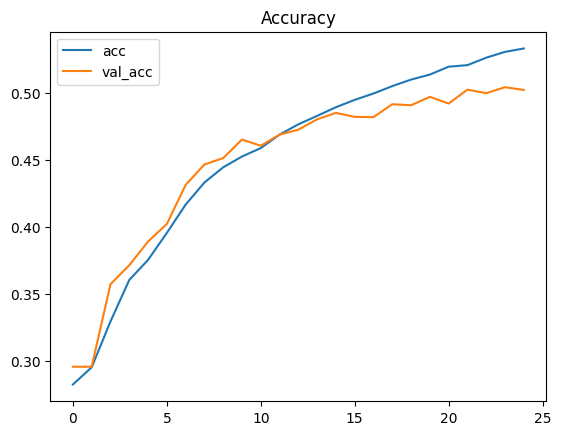

In [20]:
# visualize the training curves
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['acc', 'val_acc'])
plt.title(f'Accuracy')
plt.show()

## Test Model

Let's test our model on some examples, noting that we have to preprocess our inputs before feeding them to the model.

In [22]:
def preprocess_text(text):
    # we need to tokenize our inputs and convert them into integer codepoints
    # before passing them to the model
    text = tf.constant([txt])
    text = whitespace_tokenizer.tokenize(text)
    text = text.to_tensor(default_value="", shape=(text.shape[0], sequence_length))
    text = integerizer.integerize(text)
    return text

def predict_emotions(txt, threshold=0.5):
    # recall it is multi-class so we need to get all prediction above a threshold (0.5)
    preds = model(preprocess_text(text))[0]
    out = 0
    for i in range(NUM_CLASSES):
        if preds[i] > threshold:
            emotion_name = CLASSES[i]
            emotion_prob = round(float(preds[i]) * 100, 1)
            print(f"{emotion_name} ({emotion_prob})%")
            out += 1
    if not out:
        print("neutral")

In [23]:
txt = "I enjoy having a good icecream."
predict_emotions(txt)

joy (84.5)%


In [24]:
# the model works even with typos, substitutions, and emojis!
txt = "I enjoy hving a g00d ic3cream!!! 🍦"
predict_emotions(txt)

joy (85.9)%
